In [1]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore
import gzip
import os
import seaborn as sns
import csv
from alive_progress import alive_bar
from collections import defaultdict
import time
import cProfile
import concurrent.futures

c:\Users\bincl\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
import pandas as pd

start_date = 1800
end_date = 2000
numbers = list(range(start_date,end_date))

conf= SparkConf().setAll([('spark.executor.memory', '16g'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','16g')])
spark = SparkSession.builder.config(conf=conf).appName('NgramSQL').getOrCreate()

#spark = SparkSession.builder.appName('3gramSQL').getOrCreate()
df_2gram = spark.read.parquet("C:/Users/bincl/BA-Thesis/Dataset/2gram/warehouse/2gram_table")   

In [3]:
def get_pd_df_old(df):
    matched_pandas_df = pd.Series(df)
    matched_pandas_df.sort_index(inplace = True)
    matched_pandas_df.index.astype('int')
    matched_pandas_df = matched_pandas_df.reindex(numbers, fill_value= 0)
    return matched_pandas_df


In [4]:
def get_pd_df(df):
    matched_pandas_df = pd.Series(df).astype(int).reindex(numbers, fill_value=0)
    return matched_pandas_df

In [5]:
def MLR(full,left,right):
    X = pd.concat([left,right],axis=1)
    reg = LinearRegression()
    reg.fit(X, full) 
    return reg.coef_,reg.intercept_,X

def buildApproximation_old(c1,c2,basevalue,df):
    df = df.astype('float')
    
    df = df.fillna(0)
    
    df['scaledFirst'] = df.iloc[:,0].apply(lambda x: x * c1) 
    df['scaledLast'] = df.iloc[:,1].apply(lambda x: x * c2) 
    df['approximation'] = df['scaledFirst'] + df['scaledLast'] + basevalue
    return df

In [6]:
def buildApproximation(c1, c2, basevalue, df):
    df = df.fillna(0)
    df['approximation'] = c1 * df.iloc[:, 0] + c2 * df.iloc[:, 1] + basevalue
    return df

In [7]:
def parallel_compressWithError2gram(n, error):
    df_2_gram = df_2gram.head(n)
    result_list = []
    all_results = []
    sum_results = []

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {executor.submit(compress_single, df_2_gram[i], error): i for i in range(n)}
        for future in concurrent.futures.as_completed(futures):
            i = futures[future]
            try:
                result, all, sum_value = future.result()
                if result is not None:
                    result_list.extend(result)  # Use the correct variable name here
                all_results.append(all)
                sum_results.append(sum_value)
            except Exception as e:
                print(f"Error processing item {i}: {e}")

    return  result,all_results, sum_results


def compress_single(df_file, error):
   
    
    full = get_pd_df(df_file['Frequency_N'])
    left = get_pd_df(df_file['Frequency_L'])
    right = get_pd_df(df_file['Frequency_R'])
    
    if not (full.eq(0).all() or right.eq(0).all() or left.eq(0).all()):
        coef, intercept, dfAprox = MLR(full, left, right)
        c1, c2 = coef
        df = buildApproximation(c1, c2, intercept, dfAprox)
        
        dfOriginal = pd.DataFrame({'values': pd.to_numeric(full), 'zscore': zscore(full)})
        df['zscore'] = zscore(df['approximation'])
        
        if not df.isnull().values.any():
            sum_value = pd.to_numeric(dfOriginal['values']).sum()
            rmse = mean_squared_error(dfOriginal['zscore'], df['zscore'], squared=False)
            
            if rmse <= error:
                result = [rmse, dfOriginal['values'], dfOriginal['zscore'], df['approximation'], df['zscore']]
                return result, rmse, sum_value
                
            else: 
                return None, rmse, sum_value
    return None, None, None

In [8]:
def compressWithError2gram(n,error):
    df_2_gram = df_2gram.head(n)
    result = []
    all = []
    sum = []
    
    with alive_bar(n,length= 20, force_tty = True, bar = 'smooth') as bar:
        for i in range(n):
            df_file = df_2_gram[i]
            full = get_pd_df(df_file['Frequency_N'])
            left = get_pd_df(df_file['Frequency_L'])
            right =  get_pd_df(df_file['Frequency_R'])
            if not(full.eq(0).all() or right.eq(0).all() or left.eq(0).all()):
                coef,intercept,dfAprox = MLR(full,left,right)
                c1,c2 = coef
                df = buildApproximation(c1,c2,intercept,dfAprox)
                dfOriginal = pd.DataFrame({'values': pd.to_numeric(full), 'zscore': zscore(full)})
                df['zscore'] = zscore(df['approximation'])
                if not(df.isnull().values.any()):
                    sum.append(pd.to_numeric(dfOriginal['values']).sum()) 
                    rmse = mean_squared_error(dfOriginal['zscore'], df['zscore'], squared = False)
                    if rmse <= error:
                        result.append([rmse,dfOriginal['values'],dfOriginal['zscore'],df['approximation'],df['zscore']]) 
                    all.append(rmse)    
            bar()
    return result, all, sum


In [9]:
#cProfile.run('compressWithError2gram(1000, 1)', sort = 'cumulative')
result,all, sum = parallel_compressWithError2gram(1000, 1)
print(all)
print(len(all))
print(sum)
print(len(sum))

[1.2500142710319573, 0.9861241303361501, 1.1397927237521623, 1.2196926716297103, 1.1548744042402341, 1.3783068893975778, 0.7528536471734235, 1.1677694738822089, 1.3789458752276162, 1.1375484241221328, 1.1212818673508016, 1.3549202974232786, 0.9414197102438058, 0.8191041088350618, 1.052322082946023, 1.1738421923217708, 0.9857554085171311, 1.1282671568067375, 1.2430073302339144, 1.0634923578500093, 1.1264140822733575, 0.8575854427974249, 1.2660159710771246, 1.3019186568200924, 1.3716504042154198, 1.1396047481443048, 1.1951019231117648, 0.5046730193192337, 1.0188619313236855, 1.0678078730085026, 1.1273518565696188, 1.3026404639675895, 0.8949408335638469, 1.0183118068119263, 1.1371332040539663, 1.1546026607918765, 1.046433438098326, 1.0257493361530732, 1.1750460540816805, 1.1417008620725804, 1.063738413644996, 1.0427610297957515, 1.3460358417185965, 0.7828092657928402, 1.1172256405657899, 1.1206361054337048, 1.1746033059780832, 1.0363443600821078, 1.0358452928276893, 0.5914138335726276, 1.

In [10]:
result, all, sum = compressWithError2gram(1000, 1)
print(len(result))
print(all)
print(len(all))
print(sum)
print(len(sum))

|████████████████████| 1000/1000 [100%] in 4.7s (215.08/s)                      
285
[1.1556122397656214, 1.1397927237521623, 0.7528536471734235, 1.2500142710319573, 1.2430073302339144, 1.3567103952641648, 1.1417008620725804, 1.3145041825678763, 1.052322082946023, 1.1264140822733575, 0.9857554085171311, 1.3789458752276162, 1.3460358417185965, 0.9299430471249036, 1.1005703488873682, 0.7828092657928402, 1.020341790248011, 1.1546026607918765, 1.337087716256574, 0.5914138335726276, 1.2660159710771246, 1.046433438098326, 1.1396047481443048, 1.2140844267060042, 1.0363443600821078, 1.0188619313236855, 1.025708564366178, 1.187216919988106, 0.8575854427974249, 0.9414197102438058, 1.3026404639675895, 1.2597855874449648, 1.1746033059780832, 0.9861241303361501, 1.1951019231117648, 1.1212818673508016, 1.1172256405657899, 1.3716504042154198, 0.8191041088350618, 1.3019186568200924, 1.2511137456054686, 1.2196926716297103, 1.0358452928276893, 1.0183118068119263, 0.5046730193192337, 1.1738421923217708, 

In [11]:
def box(all,result):
    n = 0
    plt.boxplot(all)
    
    plt.show()
    rmse_with_error = []
    for i in result:
        rmse_with_error.append(i[0])
    plt.boxplot(rmse_with_error)
    plt.show()



    sns.violinplot(x= rmse_with_error, inner="point")
    plt.show()

In [12]:
def line(result):
    n=0
    result[n][1].plot()
    result[n][3].plot()
    plt.show()
    result[n][2].plot()
    result[n][4].plot()
    plt.show()
    print(result[n][0])

In [13]:
def scatter(sum, all):
    sns.violinplot(x= all, inner_kws=dict(box_width=15, whis_width=2, color=".8"))
    plt.show()
    plt.scatter(sum, all)
    plt.xscale('log')
    plt.show()

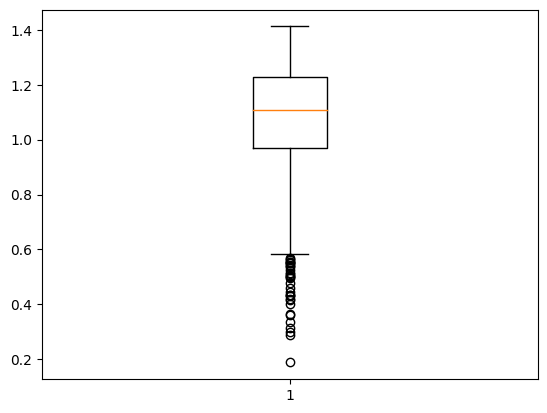

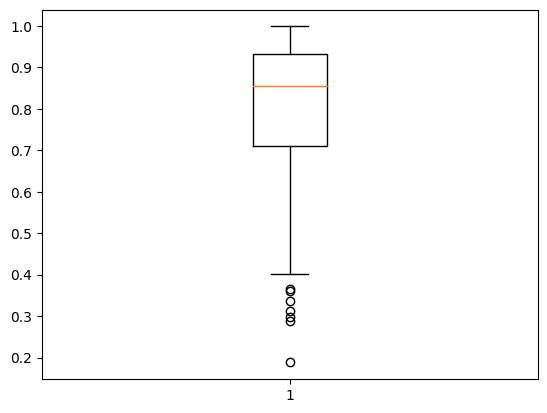

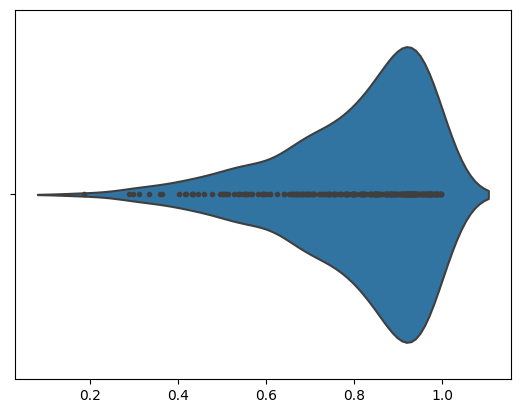

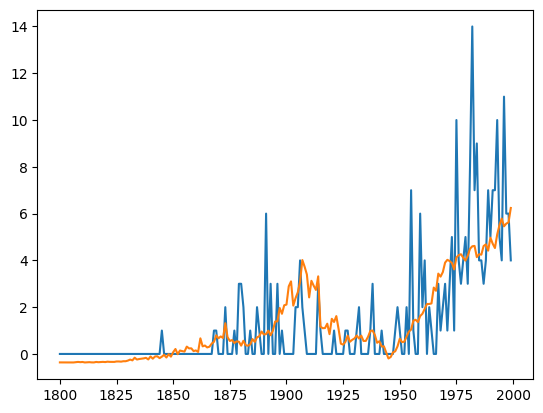

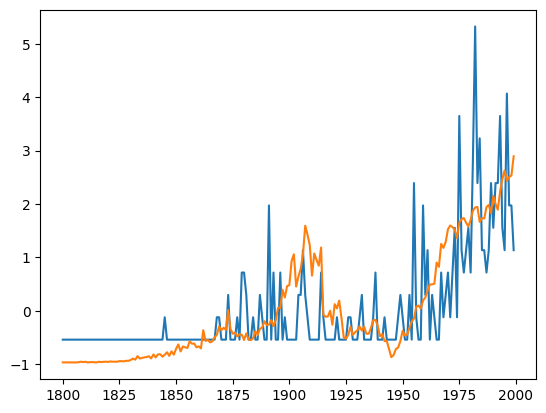

0.7528536471734235


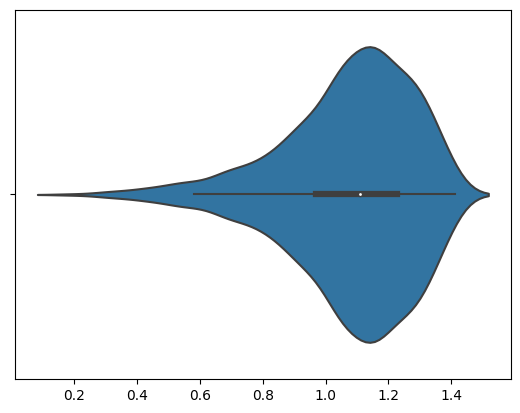

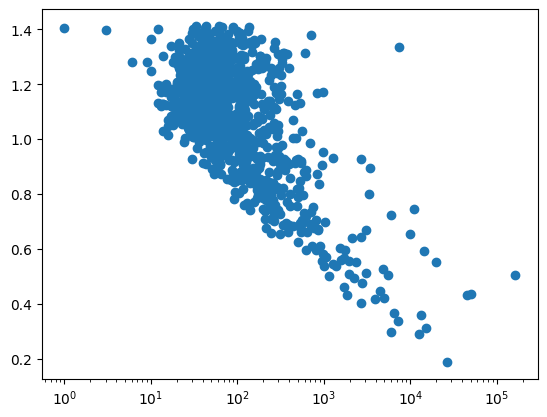

In [14]:
data_result=[]
data_all= []
data_sum = []
data_result.extend(result)
data_all.extend(all)
data_sum.extend(sum)
box(data_all,data_result)
line(data_result)
scatter(data_sum,data_all)